# Simple (generalized) Automated method for determining phase separation
- this algorithm is fast, accurate, and guarantees convergence given complete library of X_init values for each phase
- simply using species compositions should generally be enough (but testing required)


In [1]:
import numpy as np
from os import path
import pandas as pd
import scipy.optimize as opt
from scipy import optimize
import scipy.linalg as lin
import scipy as sp
import sys
import sympy as sym

from collections import OrderedDict as odict

import matplotlib.pyplot as plt

import sunkenhull as hull
from thermoengine.model import GeoCompDB, SysComp

from scipy.spatial import ConvexHull
import scipy.interpolate as interp

import ternary

Required ENKI modules (ignore the error message from Rubicon running under Python 3.6+)

In [2]:
from thermoengine import coder, core, phases, model, equilibrate

In [3]:
modelDB = model.Database(database='Berman')

## Test miscibility gap for Feldspar

In [4]:
Fsp = modelDB.get_phase('Fsp')

## P/T conditions relevant to coexisting feldspars

In [5]:
T = 900+273
P = 8e3

In [6]:
Fsp.endmember_names

array(['albite', 'anorthite', 'sanidine'], dtype='<U9')

## 

In [7]:
nmol_bulk = np.array([.5, .25, .25])
#nmol_bulk = np.array([.2, .4, .4])

In [8]:
Phs = Fsp

In [9]:
Nc = Phs.endmember_num
mu_endmem = Phs.gibbs_energy(np.full(Nc,T), np.full(Nc,P), mol=np.eye(Nc))
mu_bulk = Phs.chem_potential(T, P, mol=nmol_bulk).squeeze()
dmu_bulk = mu_bulk-mu_endmem
dG_bulk = np.dot(dmu_bulk, nmol_bulk)
X_bulk = nmol_bulk
print('dG_bulk = ', dG_bulk)
print('dmu_bulk = ', dmu_bulk)

dG_bulk =  -5315.862009870354
dmu_bulk =  [-6980.7008164  -6124.91124349 -1177.1351632 ]


In [10]:

XTOL = 1e-2

In [11]:
# Switch to true species comp (not just endmembers)
X_spec = np.eye(Nc)
mu_spec = Phs.gibbs_energy(np.full(Nc,T), np.full(Nc,P), mol=X_spec)
dmu_spec = mu_spec-mu_endmem[np.newaxis,:]
dG_spec = np.array([np.dot(imu_spec-mu_endmem, iX_spec) 
                    for imu_spec, iX_spec in zip(mu_spec, X_spec)])


In [12]:
#Phs.chem_potential(np.full(Nc,T), np.full(Nc,P), mol=X_spec)
Phs.chem_potential(T, P, mol=X_spec[1])

mu_spec = np.vstack([Phs.chem_potential(T, P, mol=iX_spec)
                    for iX_spec in X_spec])

dmu_spec = mu_spec - mu_endmem[np.newaxis,:]

In [13]:
mu = mu_endmem

In [14]:
def min_soln_energy(dmu, X_init=None, T=T, P=P, mu_endmem=mu_endmem, 
                    X_bulk=X_bulk):
    
    #A, X_min, output = Phs.affinity_and_comp(T, P, dmu+mu_endmem, X_init=X_init, ATOL=1e-6, 
    #                                         full_output=True, save_hist=save_hist)
    A, X_min = Phs.affinity_and_comp(T, P, dmu+mu_endmem, X_init=X_init, ATOL=1e-6)

    dmu_min = Phs.chem_potential(T, P, mol=X_min).squeeze()-mu_endmem
    
    #dmu_hist = output['mu_hist']-mu_endmem[np.newaxis,:]
    #X_hist = output['X_hist']
    #dG_hist = np.hstack([np.dot(idmu, iX) for idmu, iX in zip(dmu_hist, X_hist)])
    
    dG = np.dot(dmu_min, X_min)

    # output['dG_hist'] = dG_hist
    # output['dmu_hist'] = dmu_hist

    #return dG, dmu_min, X_min, output
    return dG, dmu_min, X_min


In [15]:
dmu_target = np.zeros(Nc)
X_curr = X_spec.copy()
dG_curr = np.zeros(Nc)
dmu_curr = dmu_spec.copy()


In [16]:
X_hist = [X_curr.copy()]
dG_hist = [dG_curr.copy()]
dmu_hist = [dmu_curr.copy()]


In [17]:
def hull_finder(xconstr, x, z, dztol=1e-4, ERRTOL = 1e-10):
    Ndim = xconstr.size
    z_lims = [z.min(), z.max()]
    
    dz = dztol*np.diff(z_lims)
    xz_lib = np.hstack((x, z[:, np.newaxis]))
    
    z_target = z_lims[0]
    
    nnls_err0 = 1e3*ERRTOL
    while nnls_err0 > ERRTOL:
        z_target, nnls_err0, wts0 = _update_z_target(xconstr, z_target, xz_lib, dz)


    # wt_mask = wts0>WTTOL
    inds = np.argsort(wts0)[::-1]
    ind_hull = inds[:Ndim]


    xz_hull = xz_lib[ind_hull,:]

    x_hull = xz_hull[:,:-1]
    z_hull = xz_hull[:,-1]
    output = np.linalg.lstsq(x_hull.T, xconstr, rcond=None)
    wt_hull_only = output[0]

    wt_hull = np.zeros(z.size)
    wt_hull[ind_hull] = wt_hull_only

    zconstr = np.dot(wt_hull, z)
    hull = {}
    hull['x'] = x_hull
    hull['z'] = z_hull
    hull['ind'] = ind_hull
    
    return wt_hull, zconstr, hull
    
def _update_z_target(xconstr, z_target0, xz_lib, dz):
    xz_target0 = np.hstack(( xconstr, z_target0))
    output0 = opt.nnls(xz_lib.T, xz_target0)
    nnls_err0 = output0[1]
    wts0 = output0[0]

    xz_target1 = np.hstack(( xconstr, z_target0-dz))

    output1 = opt.nnls(xz_lib.T, xz_target1)
    nnls_err1 = output1[1]
    
    dz_target = dz/(nnls_err1-nnls_err0)*nnls_err0
    
    z_target = z_target0+dz_target[0]
    return z_target, nnls_err0, wts0

In [18]:
def plot_assem(X_curr, title, ax):
    points = 100*X_curr[:,::-1]

    scale = 100
    ax.cla()
    figure, tax = ternary.figure(ax=ax, scale=scale)
    figure.set_size_inches(5, 5)
    # Plot a few different styles with a legend
    # points = random_points(30, scale=scale)
    #tax.scatter(100*tieline['mol_edges'], marker='s', color='red', label="Red Squares")

    tax.scatter(points, marker='s', color='red')
    #points = random_points(30, scale=scale)
    #tax.scatter(points, marker='D', color='green', label="Green Diamonds")
    tax.legend()
    tax.set_title(title, fontsize=20)
    tax.boundary(linewidth=2.0)
    tax.gridlines(multiple=10, color="gray")
    tax.ticks(axis='lbr', linewidth=1, multiple=10)
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')

    tax.show()

In [19]:
def iterate_assem(dmu_target, X_curr, plot_ax=None, prevwt=.3,WTTOL=1e-4, debug=False):
    TOL=1e-4
    dG_new = 0
    for i in range(Nc):
        #idG_new, idmu_new, iX_new, ioutput = min_soln_energy(
        #    dmu_target, X_init=X_curr[i], save_hist=False)
        idG_new, idmu_new, iX_new = min_soln_energy(
            dmu_target, X_init=X_curr[i])
        # print(ioutput['X_hist'])
        # print(ioutput['dmu_hist'])
        # print(ioutput['dG_hist'])
        X_hist.append(iX_new)
        dG_hist.append(idG_new)
        dmu_hist.append(idmu_new)
        #X_hist.append(ioutput['X_hist'])
        #dG_hist.append(ioutput['dG_hist'])
        #dmu_hist.append(ioutput['dmu_hist'])
        
    # idG_new, idmu_new, iX_new = min_soln_energy(dmu_target, X_init=X_bulk)
    # X_hist.append(iX_new)
    # dG_hist.append(idG_new)
    # dmu_hist.append(idmu_new)
    
    dG_hist_arr = np.hstack(dG_hist)
    X_hist_arr = np.vstack(X_hist)
    dmu_hist_arr = np.vstack(dmu_hist)
    
    wt_hull, dG_bulk, hull = hull_finder(X_bulk, X_hist_arr, dG_hist_arr)
  
    #print(wt_hull)
    #print(hull['x'])
    #print(dG_bulk)
    
    X_curr = hull['x']
    dG_curr = hull['z']
    dmu_curr = dmu_hist_arr[hull['ind']]
    wt_curr = wt_hull[hull['ind']]
    
    dG_curr_alt = [np.dot(idmu,iX) for iX,idmu in zip(X_curr, dmu_curr)]
    #X_curr = X_hist[wt_hull>WTTOL,:]
    #dG_curr = dG_hist[wt_hull>WTTOL]
    if debug:
        print('X_curr = ', X_curr)
        print('dmu_curr = ', dmu_curr)
        print('dG_curr = ', dG_curr)
        print('dG_curr_alt = ', dG_curr_alt)
        print('dG_bulk = ', dG_bulk)
    
    dmu_new = np.linalg.lstsq(X_curr, dG_curr, rcond=None)[0]
    #dmu_avg = np.mean(dmu_curr, axis=0)

    # dmu_wtavg = np.dot(wt_curr,dmu_curr)
    # dmu_avg = np.mean(dmu_curr, axis=0)
    # dmu_new = dmu_avg
    # print(dmu_wtavg)
    #dmu_new = np.linalg.lstsq(X_curr.T,hull['z'], rcond=None)[0]

    
    dmu_target = prevwt*dmu_target + (1-prevwt)*dmu_new
    # dmu_target = dmu_new

    # dG_bulk = np.dot(dmu_target, X_bulk)
    if plot_ax is not None:
        plot_assem(X_curr, dG_bulk, plot_ax)
    #print(dG_new)

    return dmu_target, X_curr, dmu_curr


In [20]:
import time
from IPython import display
time.sleep(.001)

In [21]:
iter = 0

No handles with labels found to put in legend.


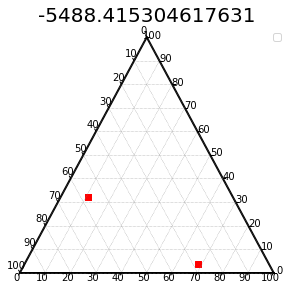

iter =  11
rms dev(dmu) =  [0.02214753 0.09167295 0.15700786]


In [37]:
fig = plt.figure()
ax = plt.gca()
#for i in range(3):
    
dmu_target, X_curr, dmu_curr = iterate_assem(dmu_target, X_curr, prevwt=.3,
                                             plot_ax=ax, debug=False)
iter +=1

dmu_dev = dmu_curr-np.mean(dmu_curr, axis=0)
rms_dev = np.sqrt(np.mean(dmu_dev**2, axis=0))
print('iter = ', iter)
print('rms dev(dmu) = ', rms_dev)

In [23]:
X_hist

[array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([0.55730786, 0.39457923, 0.0481129 ]),
 array([0.55730533, 0.39458488, 0.04810978]),
 array([0.5573075 , 0.39458005, 0.04811245])]

In [24]:
dG_curr = [np.dot(idmu,iX) for iX,idmu in zip(X_curr, dmu_curr)]
np.dot(dG_curr, X_bulk)

-3114.300640430868

In [25]:
dmu0 = Phs.chem_potential(T, P, mol=X_curr[0]).squeeze()-mu_endmem
dmu1 = Phs.chem_potential(T, P, mol=X_curr[1]).squeeze()-mu_endmem
dmu2 = Phs.chem_potential(T, P, mol=X_curr[2]).squeeze()-mu_endmem
dmu_hull = np.vstack((dmu0,dmu1,dmu2))
dmu_new = np.linalg.lstsq(X_curr, dG_curr, rcond=None)[0]

In [26]:
np.dot(dmu_hull, X_bulk)

array([  -6228.69558259, -117079.86782831,  -83418.11977019])

In [27]:
dmuavg.mean(axis=1)

NameError: name 'dmuavg' is not defined

In [ ]:
dmu_target = .3*dmu_target + .7*dmuavg.mean(axis=1)

In [ ]:
def iterate_assem_legacy(dmu_target, ax):
    TOL=1e-4
    dG_new = 0
    for i in range(Nc):
        idG_new, idmu_new, iX_new = min_soln_energy(dmu_target, X_init=X_curr[i])
        X_hist.append(iX_new)
        dG_hist.append(idG_new)
        if idG_new < dG_new:
            dG_new = idG_new
            dmu_new = idmu_new
            X_new = iX_new
    

    frac = np.zeros((Nc,Nc))
    for i in range(Nc):
        X_grp = X_curr.copy()
        X_grp[i] = X_new
        ioutput = np.linalg.lstsq(X_grp.T, X_bulk, rcond=None)
        frac[i] = ioutput[0]

    try:
        ind_replace = np.argmax(np.min(frac,axis=1))
        # ind_replace = np.where(np.all(frac>-TOL,axis=1))[0][0]
    except:
        from IPython import embed; embed()
    X_curr[ind_replace] = X_new
    dG_curr[ind_replace] = dG_new
    
    
    dmu_new = np.linalg.lstsq(X_curr, dG_curr, rcond=None)[0]

    dmu_target = 0.5*(dmu_target+dmu_new)

    dG_bulk = np.dot(dmu_target, X_bulk)
    plot_assem(X_curr, dG_bulk, ax)
    #print(dG_new)
    #print('dG_bulk = ', np.dot(dmu_target, X_bulk))

    #print(X_curr)
    #print(dG_curr)
    return dmu_target


In [ ]:
    #plt.draw()
    
    #time.sleep(0.5)
    
    
    
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    
    #display.display(plt.gcf()) 
